In [1]:
import os

def adjust_wkdir(cut_folder='notebook'):
    abspath = os.path.abspath('.')
    wk_dir = abspath.replace(cut_folder,'')
    os.chdir(wk_dir)
    return wk_dir


adjust_wkdir()

'/share/felix/pj/lung_classify/'

In [2]:


import logging
logging.basicConfig(level=logging.INFO)

import pandas as pd
import os
from task_distribute.locker import task_locker
from file_cache.cache import file_cache, logger, timed

#from tqdm._tqdm_notebook import tqdm_notebook as  tqdm

from tqdm import tqdm, tqdm_notebook
from glob import glob
import itertools
import numpy as np
from easydict import EasyDict as edict

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)



INFO:root:Start the program at:amax3, 10.10.20.103, with:Load module


yes


In [3]:
df = pd.read_csv('./input/train_bboxes.csv')
gp = df.groupby('filename').x.count().sort_index()

count_img = len(glob('./input/train/*.jpg'))
print(df.shape, gp.shape, count_img)
df.head(3)

(7167, 5) (4509,) 20013


,filename,x,y,width,height
0,6,287.0,673.0,188.0,220.0
1,8,651.0,476.0,250.0,344.0
2,18,220.0,414.0,142.0,120.0


In [4]:
df = pd.read_csv('./input/train_bboxes.csv')
df = df.drop_duplicates('filename')
df['fold'] = df.filename%5
df.fold.value_counts()

INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


1    935
2    925
4    884
0    884
3    881
Name: fold, dtype: int64

In [5]:
df = pd.read_csv('./input/train.csv', names=['filename', 'label'])
#df.head()

df.label.value_counts()

0    15504
2     2450
1     1960
3       89
4       10
Name: label, dtype: int64

In [6]:
import matplotlib.pyplot as plt
from glob import glob

file_list = list(glob('./input/train/*.jpg'))[:8]
print(file_list)
img_list = [plt.imread (file) for file in file_list]


from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(20., 50.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2,4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 share_all=True,
                 )

for ax, im in zip(grid, img_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im,cmap='gray')
plt.show()

['./input/train/8755.jpg', './input/train/158.jpg', './input/train/1570.jpg', './input/train/4223.jpg', './input/train/312.jpg', './input/train/9240.jpg', './input/train/9708.jpg', './input/train/19325.jpg']


<Figure size 2000x5000 with 16 Axes>

  file_name  label  fold
0     0.jpg      0     0
1     1.jpg      0     1
2     2.jpg      0     2
3     3.jpg      0     3
4     4.jpg      0     4 (20013, 3)
0    15504
1     1960
2     2450
3       89
4       10
Name: label, dtype: int64
(20013, 3)


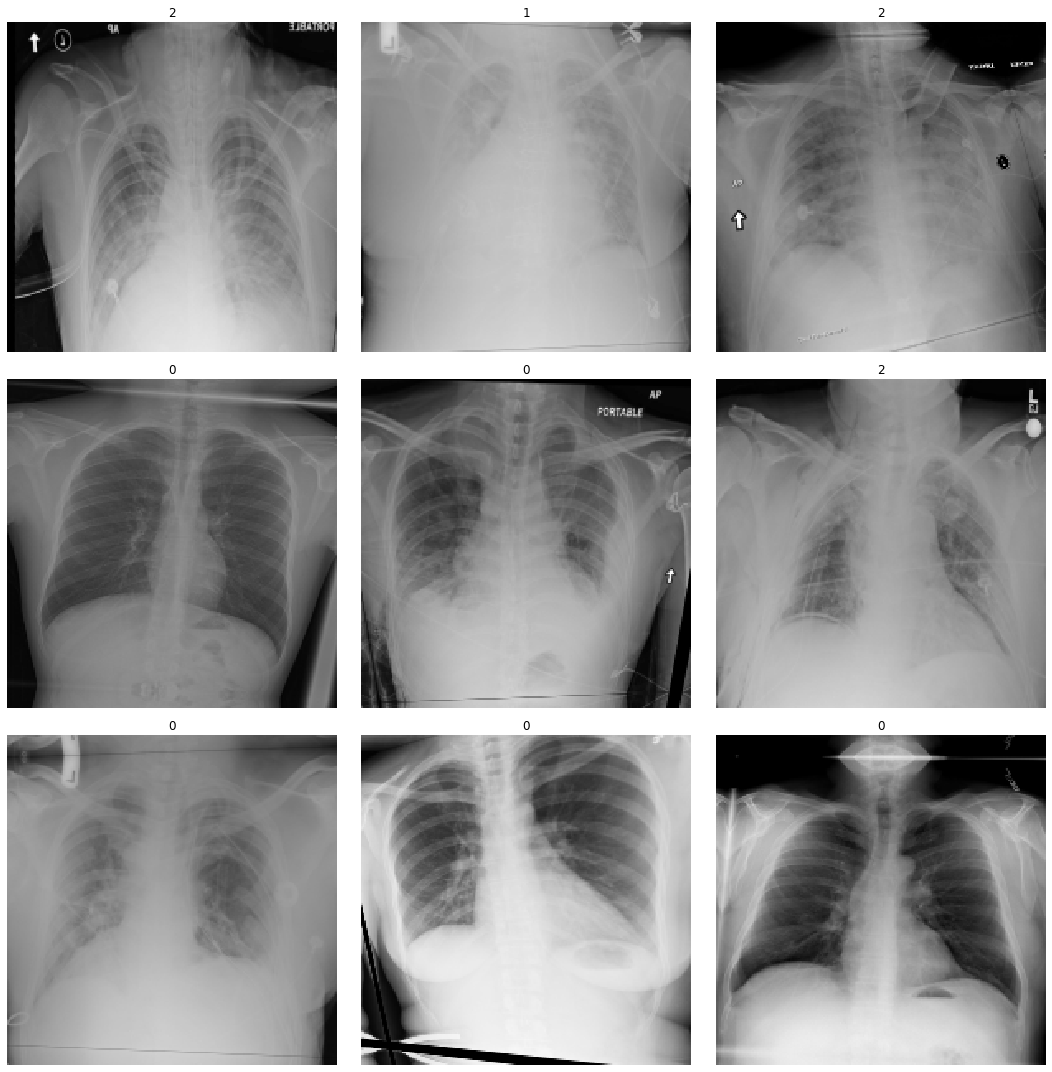

In [7]:
# df = pd.read_csv(path/'cleaned.csv', header='infer')
# print(df.head())

#https://gilberttanner.com/blog/fastai-image-classification


%reload_ext autoreload
%autoreload 2
from fastai import *
from fastai.vision import *
from fastai.widgets import *
df = pd.read_csv('./input/train.csv', names=['file_name', 'label'])
df['fold'] = df.file_name%5
df['file_name'] = df.file_name.astype('str')+'.jpg'

print(df.head(), df.shape)
#df.label = np.where(df.label>=1, 1, 0)


print(df.label.value_counts().sort_index())

print(df.shape)
tfms = get_transforms(do_flip=False)

valid_fold = 4
data = (ImageDataBunch.from_df( './input/train/', df)
                    #.split_by_rand_pct(0.2)
                    .split_by_valid_func(lambda o: int(os.path.basename(o).split('.')[0])%5==valid_fold)  
                   .label_from_df()
                   .transform(get_transforms(), size=200)
                   .databunch(bs=16)).normalize(imagenet_stats)


data.show_batch(rows=3, figsize=(15,15))


In [8]:
df


,file_name,label,fold
0,0.jpg,0,0
1,1.jpg,0,1
2,2.jpg,0,2
3,3.jpg,0,3
4,4.jpg,0,4
...,...,...,...
20008,20008.jpg,0,3
20009,20009.jpg,0,4
20010,20010.jpg,0,0
20011,20011.jpg,1,1


In [9]:
import ssl
#ssl._create_default_https_context = ssl._create_unverified_context
learn = cnn_learner(data, models.resnet34, metrics=[ accuracy])
learn.fit_one_cycle(5)



epoch,train_loss,valid_loss,accuracy,time
0,0.748753,0.620724,0.779857,01:13
1,0.647429,0.560907,0.796383,01:18
2,0.594118,0.526949,0.811350,01:22
3,0.560697,0.511484,0.812286,01:11
4,0.523278,0.504895,0.814468,01:01


In [10]:
type(learn.loss_func), str(learn.loss_func)

(fastai.layers.FlattenedLoss, 'FlattenedLoss of CrossEntropyLoss()')

In [11]:
del learn
learn = cnn_learner(data, models.resnet50, metrics=accuracy)
learn.fit_one_cycle(5)


epoch,train_loss,valid_loss,accuracy,time
0,0.791506,0.620105,0.776115,01:13
1,0.645729,0.553360,0.806049,01:09
2,0.582417,0.519632,0.807608,01:14
3,0.550969,0.508012,0.812909,01:12
4,0.521612,0.503004,0.815404,01:14


In [12]:
type(accuracy)

function

In [13]:
os.path.exists('/home/felix/.cache/torch/checkpoints/resnet34-333f7ec4.pth')

True